<div style="
    background: linear-gradient(135deg, #f1fdf7, #dcfce7);
    color: #14532d;
    padding: 28px 32px;
    border-radius: 14px;
    box-shadow: 0 8px 18px rgba(0,0,0,0.10);
">
    <h1 style="margin:0;">📦 Classification Automatique de Produits E-commerce</h1>
    <h3 style="margin-top:8px; font-weight:normal;">
        NOTEBOOK 2 — PREPROCESSING ET FEATURE ENGINEERING AVANCÉ
    </h3>
    <p><b>Dataset :</b> flipkart_com-ecommerce_sample_1050.csv</p>
    <p><b>Objectif :</b> Pipeline complet de transformation des données en features exploitables</p>
    <p>1. Preprocessing textuel avancé (tokenization, lemmatization, POS tagging)</p>
    <p>2. Analyse et feature engineering des marques (brand)</p>
    <p>3. N-grammes et analyse contextuelle</p>
    <p>4. Feature Engineering textuel (TF-IDF, statistiques)</p>
    <p>5. Word Embeddings (introduction et features moyennes)</p>
    <p>6. Analyse de qualité et annotations</p>
    <p>7. Préparation finale des données</p>
    <p><b>Date :</b> Janvier 2026</p>
</div>

### Importation des bibliothèques nécessaires

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import pickle
from collections import Counter
import json

# NLP et preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.util import ngrams

# Sklearn preprocessing et features
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE

# Word Embeddings (Gensim)
try:
    import gensim
    from gensim.models import Word2Vec
    GENSIM_AVAILABLE = True
except ImportError:
    GENSIM_AVAILABLE = False
    print(" Gensim n'est pas installé. Word Embeddings seront désactivés.")

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Couleurs personnalisées
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'warning': '#F24236',
    'info': '#4ECDC4',
    'purple': '#9B5DE5',
    'yellow': '#F9C74F',
    'teal': '#06FFA5',
    'orange': '#FF6B35',
    'pink': '#FF006E',
    'blue': '#0077B6'
}

print("⏳ Téléchargement des ressources NLTK...")
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 
                 'maxent_ne_chunker', 'words', 'omw-1.4']:
    try:
        if resource == 'punkt':
            nltk.data.find('tokenizers/punkt')
        elif resource in ['stopwords', 'wordnet', 'words', 'omw-1.4']:
            nltk.data.find(f'corpora/{resource}')
        else:
            nltk.data.find(f'taggers/{resource}')
    except LookupError:
        print(f"  Téléchargement de {resource}...")
        nltk.download(resource, quiet=True)

print("✅ Bibliothèques importées avec succès !")
print("="*80)

 Gensim n'est pas installé. Word Embeddings seront désactivés.
⏳ Téléchargement des ressources NLTK...
  Téléchargement de wordnet...
  Téléchargement de maxent_ne_chunker...
  Téléchargement de omw-1.4...
✅ Bibliothèques importées avec succès !


[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading maxent_ne_chunker: <urlopen error [Errno
[nltk_data]     11001] getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


### CHARGEMENT DES DONNÉES

In [51]:
DATA_PATH = '../outputs/flipkart_data_eda.csv'

print(f" Chargement du dataset depuis : {DATA_PATH}\n")

try:
    df = pd.read_csv(DATA_PATH, encoding='utf-8')
    print(" Dataset chargé avec succès !")
except Exception as e:
    print(f" Erreur : {e}")
    raise

print(f"\n INFORMATIONS GÉNÉRALES :")
print(f"Nombre de produits : {len(df):,}")
print(f"Nombre de colonnes : {df.shape[1]}")

print(f"\n Colonnes disponibles :")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*80)

 Chargement du dataset depuis : ../outputs/flipkart_data_eda.csv

 Dataset chargé avec succès !

 INFORMATIONS GÉNÉRALES :
Nombre de produits : 1,049
Nombre de colonnes : 21

 Colonnes disponibles :
   1. uniq_id
   2. crawl_timestamp
   3. product_url
   4. product_name
   5. product_category_tree
   6. pid
   7. retail_price
   8. discounted_price
   9. image
  10. is_FK_Advantage_product
  11. description
  12. product_rating
  13. overall_rating
  14. brand
  15. product_specifications
  16. category_level1
  17. category_level2
  18. category_level3
  19. retail_price_clean
  20. discounted_price_clean
  21. discount_rate



#### SÉLECTION DES FEATURES PERTINENTES

In [52]:
print("\n" + "="*80)
print(" SÉLECTION DES FEATURES POUR LA CLASSIFICATION")
print("="*80 + "\n")

# Features textuelles principales
text_features = []
for feat in ['product_name', 'description']:
    if feat in df.columns:
        text_features.append(feat)

# Features numériques
numeric_features = []
for feat in ['discounted_price_clean']:
    if feat in df.columns:
        numeric_features.append(feat)

# Features catégorielles (avec brand en priorité !)
categorical_features = []
for feat in ['brand']:
    if feat in df.columns:
        categorical_features.append(feat)

# Target
category_target = 'category_level1'

# Affichage
print(f"✅ Features textuelles      : {text_features}")
print(f"✅ Features numériques      : {numeric_features}")
print(f"✅ Features catégorielles   : {categorical_features}")
print(f"✅ Variable cible (target)  : {category_target}")

df_clean = df[df[category_target].notna()].copy()
print(f"\n📦 Produits avec catégorie valide : {len(df_clean):,}")
print(f"🗑️  Produits supprimés (catégorie manquante) : {len(df) - len(df_clean):,}")

print("\n" + "="*80)


 SÉLECTION DES FEATURES POUR LA CLASSIFICATION

✅ Features textuelles      : ['product_name', 'description']
✅ Features numériques      : ['discounted_price_clean']
✅ Features catégorielles   : ['brand']
✅ Variable cible (target)  : category_level1

📦 Produits avec catégorie valide : 1,049
🗑️  Produits supprimés (catégorie manquante) : 0



### ANALYSE APPROFONDIE DES MARQUES (BRAND)

In [53]:
print("\n" + "="*80)
print(" ANALYSE APPROFONDIE DES MARQUES")
print("="*80 + "\n")

if 'brand' in df_clean.columns:
    # Gérer les valeurs manquantes
    df_clean['brand'] = df_clean['brand'].fillna('Unknown')
    
    # Statistiques globales
    n_brands = df_clean['brand'].nunique()
    n_unknown = (df_clean['brand'] == 'Unknown').sum()
    
    print(f" Statistiques des marques :")
    print(f"  • Nombre total de marques : {n_brands:,}")
    print(f"  • Produits sans marque : {n_unknown:,} ({n_unknown/len(df_clean)*100:.1f}%)")
    print(f"  • Produits avec marque : {len(df_clean) - n_unknown:,} ({(len(df_clean) - n_unknown)/len(df_clean)*100:.1f}%)")
    
    # Top marques
    brand_counts = df_clean['brand'].value_counts()
    print(f"\n Top 15 des marques les plus représentées :")
    print(brand_counts.head(15).to_string())
    
    print("\n" + "="*80)
else:
    print(" La colonne 'brand' n'existe pas dans le dataset")
    print("="*80)


 ANALYSE APPROFONDIE DES MARQUES

 Statistiques des marques :
  • Nombre total de marques : 490
  • Produits sans marque : 338 (32.2%)
  • Produits avec marque : 711 (67.8%)

 Top 15 des marques les plus représentées :
brand
Unknown           338
Lapguard           11
PRINT SHAPES       11
Lal Haveli         10
Raymond             8
Aroma Comfort       8
Tenda               7
Smartpro            7
Wallmantra          7
Asus                6
HP                  6
Home Originals      6
AKUP                5
Exotic India        5
FS Mini Klub        5



### VISUALISATION : MARQUES vs CATÉGORIES


 VISUALISATION : MARQUES vs CATÉGORIES



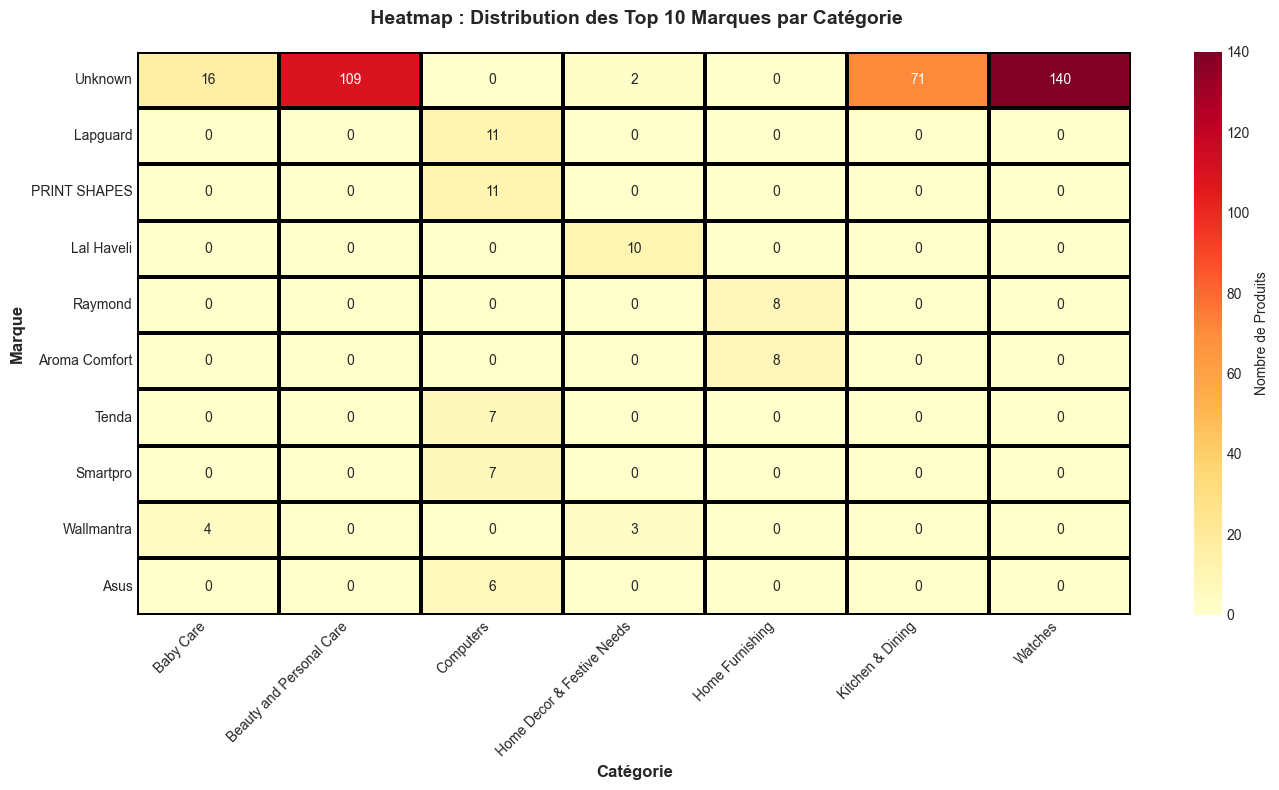


 SPÉCIALISATION DES MARQUES :
(Concentration sur une catégorie principale)

       Marque       Catégorie_principale Concentration (%)  Total_produits
   Wallmantra                  Baby Care              57.1               7
      Unknown                    Watches              41.4             338
     Lapguard                  Computers             100.0              11
 PRINT SHAPES                  Computers             100.0              11
   Lal Haveli Home Decor & Festive Needs             100.0              10
      Raymond            Home Furnishing             100.0               8
Aroma Comfort            Home Furnishing             100.0               8
        Tenda                  Computers             100.0               7
     Smartpro                  Computers             100.0               7
         Asus                  Computers             100.0               6

 Insight : Les marques >70% sont fortement spécialisées


In [54]:
print("\n VISUALISATION : MARQUES vs CATÉGORIES\n")

# Création d'une heatmap des top 10 marques vs catégories
top_10_brands = brand_counts.head(10).index
brand_category_crosstab = pd.crosstab(
    df_clean['brand'], 
    df_clean[category_target]
)
brand_category_top = brand_category_crosstab.loc[top_10_brands]

# Visualisation
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(brand_category_top, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=1.5, linecolor='black', 
            cbar_kws={'label': 'Nombre de Produits'}, ax=ax)
ax.set_xlabel('Catégorie', fontsize=12, fontweight='bold')
ax.set_ylabel('Marque', fontsize=12, fontweight='bold')
ax.set_title(' Heatmap : Distribution des Top 10 Marques par Catégorie', 
            fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/brand_category_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcul de la spécialisation des marques
print("\n SPÉCIALISATION DES MARQUES :")
print("(Concentration sur une catégorie principale)\n")

brand_specialization = []
for brand in top_10_brands:
    brand_data = brand_category_top.loc[brand]
    total = brand_data.sum()
    max_category = brand_data.idxmax()
    max_pct = (brand_data.max() / total) * 100
    brand_specialization.append({
        'Marque': brand,
        'Catégorie_principale': max_category,
        'Concentration (%)': f"{max_pct:.1f}",
        'Total_produits': total
    })

specialization_df = pd.DataFrame(brand_specialization).sort_values(
    'Concentration (%)', ascending=False
)
print(specialization_df.to_string(index=False))

print("\n Insight : Les marques >70% sont fortement spécialisées")
print("="*80)

### PIPELINE DE PREPROCESSING TEXTUEL - VISUALISATION


 PIPELINE DE PREPROCESSING TEXTUEL AVANCÉ



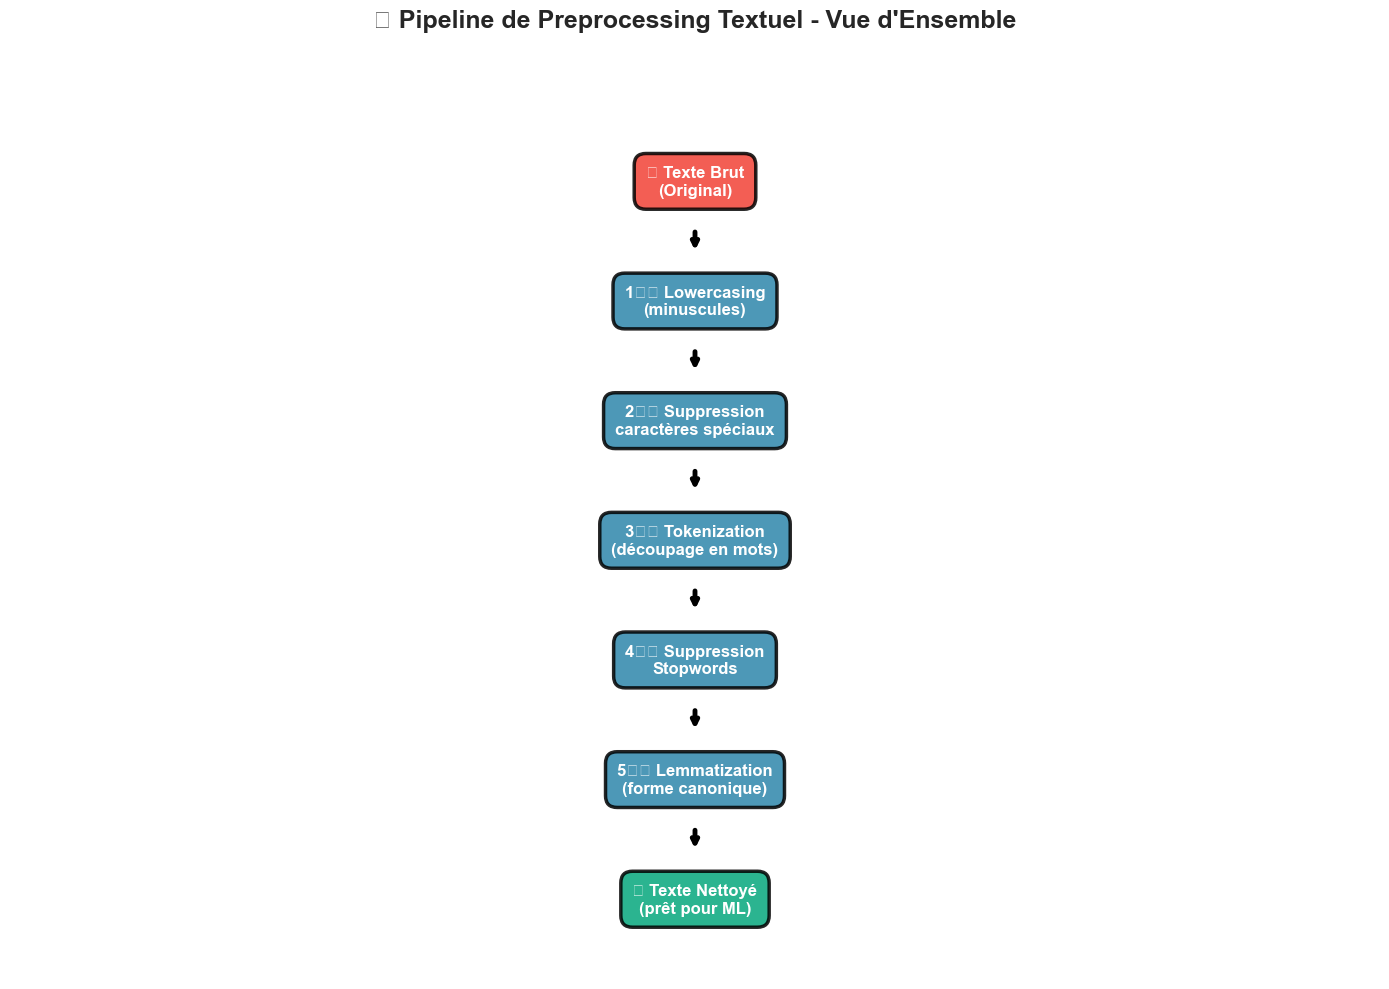

In [55]:
print("\n" + "="*80)
print(" PIPELINE DE PREPROCESSING TEXTUEL AVANCÉ")
print("="*80 + "\n")

# Initialisation des outils NLP
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Visualisation du pipeline
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')

pipeline_steps = [
    "📄 Texte Brut\n(Original)",
    "1️⃣ Lowercasing\n(minuscules)",
    "2️⃣ Suppression\ncaractères spéciaux",
    "3️⃣ Tokenization\n(découpage en mots)",
    "4️⃣ Suppression\nStopwords",
    "5️⃣ Lemmatization\n(forme canonique)",
    "✅ Texte Nettoyé\n(prêt pour ML)"
]

# Positions et couleurs
y_positions = [0.85, 0.70, 0.55, 0.40, 0.25, 0.10, -0.05]
colors_pipeline = [
    COLORS['warning'], COLORS['primary'], COLORS['primary'], 
    COLORS['primary'], COLORS['primary'], COLORS['primary'], 
    COLORS['success']
]

for i, (step, y, color) in enumerate(zip(pipeline_steps, y_positions, colors_pipeline)):
    # Box pour chaque étape
    bbox_props = dict(boxstyle='round,pad=0.7', facecolor=color, 
                     edgecolor='black', linewidth=2.5, alpha=0.85)
    ax.text(0.5, y, step, ha='center', va='center', fontsize=12, 
           fontweight='bold', bbox=bbox_props, color='white')
    
    # Flèche vers l'étape suivante
    if i < len(pipeline_steps) - 1:
        ax.annotate('', xy=(0.5, y_positions[i+1]+0.06), xytext=(0.5, y-0.06),
                   arrowprops=dict(arrowstyle='->', lw=3.5, color='black'))

ax.set_xlim(0, 1)
ax.set_ylim(-0.15, 1)
ax.set_title('📊 Pipeline de Preprocessing Textuel - Vue d\'Ensemble', 
            fontsize=18, fontweight='bold', pad=25)
plt.tight_layout()
plt.savefig('../outputs/preprocessing_pipeline.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)

### FONCTION DE NETTOYAGE AVANCÉE

In [56]:
def clean_text_advanced(text, use_lemmatization=True, remove_stopwords=True, 
                       min_word_length=2, return_tokens=False):
    """
    Nettoie et prétraite un texte avec des options avancées
    
    Paramètres :
    -----------
    text : str
        Texte à nettoyer
    use_lemmatization : bool
        Si True, utilise la lemmatization, sinon stemming
    remove_stopwords : bool
        Si True, supprime les stopwords
    min_word_length : int
        Longueur minimale des mots à conserver
    return_tokens : bool
        Si True, retourne une liste de tokens au lieu d'une chaîne
    
    Retourne :
    ---------
    str ou list : Texte nettoyé ou liste de tokens
    """
    if pd.isna(text):
        return [] if return_tokens else ""
    
    # 1. Conversion en string et en minuscules
    text = str(text).lower()
    
    # 2. Suppression des caractères spéciaux (garder lettres, chiffres, espaces)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # 3. Suppression des chiffres isolés
    text = re.sub(r'\b\d+\b', '', text)
    
    # 4. Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 5. Tokenization
    tokens = text.split()
    
    # 6. Suppression des stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    
    # 7. Lemmatization ou Stemming
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    else:
        tokens = [stemmer.stem(word) for word in tokens]
    
    # 8. Suppression des mots trop courts
    tokens = [word for word in tokens if len(word) >= min_word_length]
    
    # 9. Retour
    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

# Testons d'abord la fonction avec plusieurs exemples
print("\n📝 EXEMPLES DE NETTOYAGE TEXTUEL :\n")

test_samples = [
    "Samsung Galaxy S21 5G - 128GB Storage!!! Amazing phone for $999.99 #BestDeal",
    "Nike Air Max 270 React - Men's Running Shoes (Size: 10)",
    "Apple MacBook Pro 16\" - M1 Pro Chip, 16GB RAM, 512GB SSD"
]

for i, sample in enumerate(test_samples, 1):
    print(f"Exemple {i}:")
    print(f"  Original : {sample}")
    print(f"  Nettoyé  : {clean_text_advanced(sample)}")
    print(f"  Tokens   : {clean_text_advanced(sample, return_tokens=True)}")
    print()

print("="*80)


📝 EXEMPLES DE NETTOYAGE TEXTUEL :

Exemple 1:
  Original : Samsung Galaxy S21 5G - 128GB Storage!!! Amazing phone for $999.99 #BestDeal
  Nettoyé  : samsung galaxy s21 5g 128gb storage amazing phone bestdeal
  Tokens   : ['samsung', 'galaxy', 's21', '5g', '128gb', 'storage', 'amazing', 'phone', 'bestdeal']

Exemple 2:
  Original : Nike Air Max 270 React - Men's Running Shoes (Size: 10)
  Nettoyé  : nike air max react men running shoe size
  Tokens   : ['nike', 'air', 'max', 'react', 'men', 'running', 'shoe', 'size']

Exemple 3:
  Original : Apple MacBook Pro 16" - M1 Pro Chip, 16GB RAM, 512GB SSD
  Nettoyé  : apple macbook pro m1 pro chip 16gb ram 512gb ssd
  Tokens   : ['apple', 'macbook', 'pro', 'm1', 'pro', 'chip', '16gb', 'ram', '512gb', 'ssd']



#### APPLICATION DU NETTOYAGE SUR LE DATASET

In [57]:
print("\n" + "="*80)
print(" APPLICATION DU NETTOYAGE SUR LE DATASET")
print("="*80 + "\n")
print("Cela peut prendre quelques minutes, veuillez patienter...\n")

# Appliquons le nettoyage sur les colonnes textuelles
for col in text_features:
    if col in df_clean.columns:
        print(f" Nettoyage de '{col}'...")
        
        cleaned_texts = []
        total = len(df_clean)
        
        for idx, text in enumerate(df_clean[col]):
            if idx % 100 == 0:
                progress = (idx / total) * 100
                print(f"  Progression: {progress:.1f}% ({idx}/{total})", end='\r')
            
            cleaned_texts.append(clean_text_advanced(text, use_lemmatization=True, 
                                                    remove_stopwords=True))
        
        df_clean[f'{col}_clean'] = cleaned_texts
        print(f"  ✅ Terminé ! ({len(cleaned_texts)} textes nettoyés)" + " "*20)

print("\n✅ Nettoyage des textes terminé !")
print("="*80)


 APPLICATION DU NETTOYAGE SUR LE DATASET

Cela peut prendre quelques minutes, veuillez patienter...

 Nettoyage de 'product_name'...
  ✅ Terminé ! (1049 textes nettoyés)                    
 Nettoyage de 'description'...
  ✅ Terminé ! (1049 textes nettoyés)                    

✅ Nettoyage des textes terminé !


### VISUALISATION AVANT/APRÈS NETTOYAGE


 VISUALISATION AVANT/APRÈS NETTOYAGE :



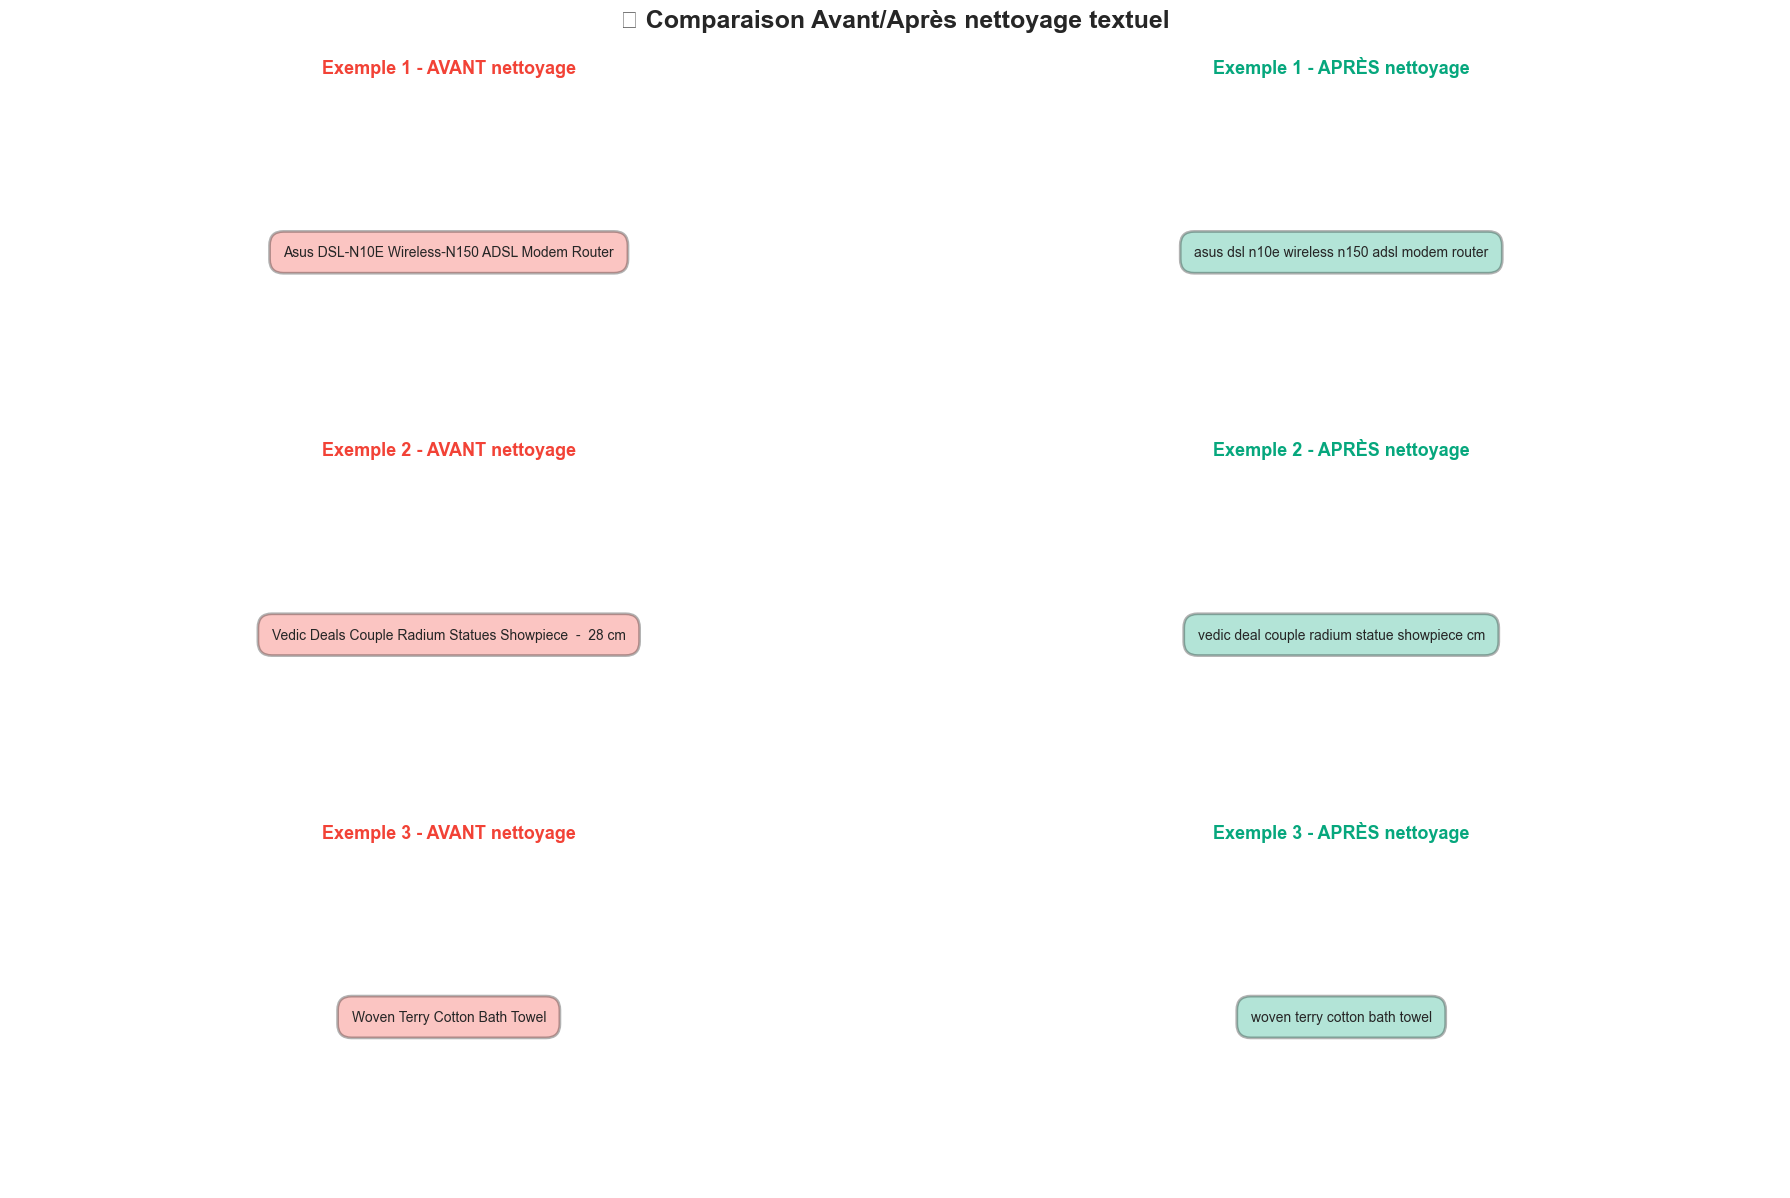

In [58]:
print("\n VISUALISATION AVANT/APRÈS NETTOYAGE :\n")

# Sélection de 3 exemples aléatoires
np.random.seed(42)
sample_indices = np.random.choice(df_clean.index, 3, replace=False)

fig, axes = plt.subplots(3, 2, figsize=(18, 12))

for i, idx in enumerate(sample_indices):
    # Textes original et nettoyé
    if 'product_name' in df_clean.columns:
        original = str(df_clean.loc[idx, 'product_name'])[:200]
        cleaned = str(df_clean.loc[idx, 'product_name_clean'])[:200]
        
        # Avant
        axes[i, 0].text(0.5, 0.5, original, ha='center', va='center', 
                       wrap=True, fontsize=10, 
                       bbox=dict(boxstyle='round,pad=1', facecolor=COLORS['warning'], 
                                alpha=0.3, edgecolor='black', linewidth=2))
        axes[i, 0].set_title(f'Exemple {i+1} - AVANT nettoyage', 
                            fontweight='bold', fontsize=13, color=COLORS['warning'])
        axes[i, 0].axis('off')
        
        # Après
        axes[i, 1].text(0.5, 0.5, cleaned, ha='center', va='center', 
                       wrap=True, fontsize=10, 
                       bbox=dict(boxstyle='round,pad=1', facecolor=COLORS['success'], 
                                alpha=0.3, edgecolor='black', linewidth=2))
        axes[i, 1].set_title(f'Exemple {i+1} - APRÈS nettoyage', 
                            fontweight='bold', fontsize=13, color=COLORS['success'])
        axes[i, 1].axis('off')

plt.suptitle('📊 Comparaison Avant/Après nettoyage textuel', 
            fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../outputs/text_cleaning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*80)

### CRÉATION DE FEATURES TEXTUELLES COMBINÉES

In [59]:
print("\n" + "="*80)
print("🔗 CRÉATION DE FEATURES TEXTUELLES COMBINÉES")
print("="*80 + "\n")

# Listons les colonnes nettoyées disponibles
text_columns_clean = [f'{col}_clean' for col in text_features 
                      if f'{col}_clean' in df_clean.columns]

print(f"Colonnes à combiner : {text_columns_clean}")

if len(text_columns_clean) > 0:
    # Création la colonne combinée
    combined_texts = []
    for idx in range(len(df_clean)):
        parts = []
        for col in text_columns_clean:
            text = df_clean.iloc[idx][col]
            if pd.notna(text) and str(text).strip():
                parts.append(str(text))
        combined_texts.append(' '.join(parts))
    
    df_clean['text_combined'] = combined_texts
    print(f"✅ Colonne 'text_combined' créée ({len(combined_texts)} textes)")
    
    # Statistiques
    avg_length = np.mean([len(t.split()) for t in combined_texts])
    print(f"   • Longueur moyenne : {avg_length:.1f} mots")
else:
    print(" Aucune colonne textuelle nettoyée disponible")
    df_clean['text_combined'] = ""

# Affichages des exemples
print("\n Exemples de textes combinés :")
sample_df = df_clean[['product_name', 'text_combined']].head(3)
for idx, row in sample_df.iterrows():
    print(f"\nProduit : {row['product_name'][:60]}...")
    print(f"Combiné : {row['text_combined'][:100]}...")

print("\n" + "="*80)


🔗 CRÉATION DE FEATURES TEXTUELLES COMBINÉES

Colonnes à combiner : ['product_name_clean', 'description_clean']
✅ Colonne 'text_combined' créée (1049 textes)
   • Longueur moyenne : 58.9 mots

 Exemples de textes combinés :

Produit : Elegance Polyester Multicolor Abstract Eyelet Door Curtain...
Combiné : elegance polyester multicolor abstract eyelet door curtain key feature elegance polyester multicolor...

Produit : Sathiyas Cotton Bath Towel...
Combiné : sathiyas cotton bath towel specification sathiyas cotton bath towel bath towel red yellow blue bath ...

Produit : SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsh...
Combiné : santosh royal fashion cotton printed king sized double bedsheet key feature santosh royal fashion co...



### N-GRAMMES : EXTRACTION ET ANALYSE


 EXTRACTION ET ANALYSE DES N-GRAMMES

 Extraction des n-grammes les plus fréquents...

✅ Extraction terminée sur 500 produits
  • Bigrammes extraits : 29,298
  • Trigrammes extraits : 28,798


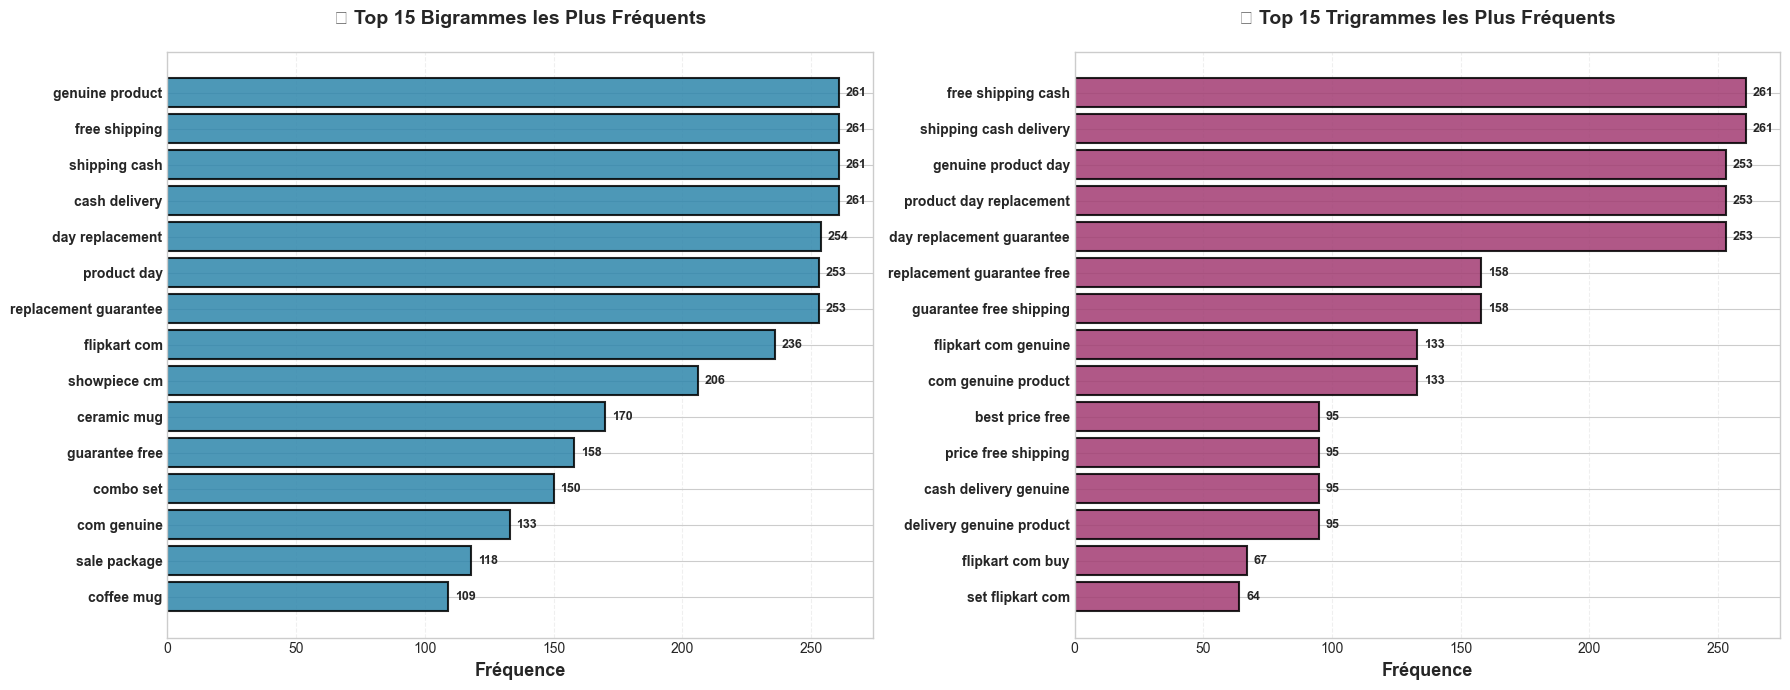


✅ Analyse des n-grammes terminée !



In [60]:
print("\n" + "="*80)
print(" EXTRACTION ET ANALYSE DES N-GRAMMES")
print("="*80 + "\n")

def extract_ngrams(text, n=2):
    """Extrait les n-grammes d'un texte"""
    tokens = clean_text_advanced(text, return_tokens=True)
    if len(tokens) < n:
        return []
    return list(ngrams(tokens, n))

# Extraction des bigrammes et trigrammes pour analyse
print(" Extraction des n-grammes les plus fréquents...\n")

all_bigrams = []
all_trigrams = []

# Limite à 500 pour la vitesse
sample_size = min(500, len(df_clean))
for text in df_clean['text_combined'].head(sample_size):
    all_bigrams.extend(extract_ngrams(text, n=2))
    all_trigrams.extend(extract_ngrams(text, n=3))

# Top bigrammes et trigrammes
bigram_freq = Counter(all_bigrams).most_common(15)
trigram_freq = Counter(all_trigrams).most_common(15)

print(f"✅ Extraction terminée sur {sample_size} produits")
print(f"  • Bigrammes extraits : {len(all_bigrams):,}")
print(f"  • Trigrammes extraits : {len(all_trigrams):,}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Bigrammes
if bigram_freq:
    bigrams, counts = zip(*bigram_freq)
    bigrams_str = [' '.join(b) for b in bigrams]
    
    y_pos = np.arange(len(bigrams_str))
    axes[0].barh(y_pos, counts, color=COLORS['primary'], 
                edgecolor='black', linewidth=1.5, alpha=0.85)
    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(bigrams_str, fontsize=10, fontweight='bold')
    axes[0].set_xlabel('Fréquence', fontsize=13, fontweight='bold')
    axes[0].set_title('📊 Top 15 Bigrammes les Plus Fréquents', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(axis='x', alpha=0.3, linestyle='--')
    axes[0].invert_yaxis()
    
    # Ajout valeurs
    for i, v in enumerate(counts):
        axes[0].text(v + max(counts)*0.01, i, str(v), 
                    va='center', fontweight='bold', fontsize=9)

# Trigrammes
if trigram_freq:
    trigrams, counts = zip(*trigram_freq)
    trigrams_str = [' '.join(t) for t in trigrams]
    
    y_pos = np.arange(len(trigrams_str))
    axes[1].barh(y_pos, counts, color=COLORS['secondary'], 
                edgecolor='black', linewidth=1.5, alpha=0.85)
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(trigrams_str, fontsize=10, fontweight='bold')
    axes[1].set_xlabel('Fréquence', fontsize=13, fontweight='bold')
    axes[1].set_title('📊 Top 15 Trigrammes les Plus Fréquents', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')
    axes[1].invert_yaxis()
    
    # Ajouter valeurs
    for i, v in enumerate(counts):
        axes[1].text(v + max(counts)*0.01, i, str(v), 
                    va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/ngrams_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Analyse des n-grammes terminée !")
print("\n" + "="*80)


### CRÉATION DE FEATURES STATISTIQUES TEXTUELLES

In [61]:
print("\n" + "="*80)
print(" CRÉATION DE FEATURES STATISTIQUES TEXTUELLES")
print("="*80 + "\n")

# Longueur en caractères
df_clean['text_length_chars'] = df_clean['text_combined'].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)

# Nombre de mots
df_clean['text_length_words'] = df_clean['text_combined'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)

# Nombre de mots uniques
df_clean['text_unique_words'] = df_clean['text_combined'].apply(
    lambda x: len(set(str(x).split())) if pd.notna(x) else 0
)

# Ratio mots uniques / total mots (diversité lexicale)
df_clean['text_lexical_diversity'] = (
    df_clean['text_unique_words'] / (df_clean['text_length_words'] + 1)
)

# Longueur moyenne des mots
df_clean['text_avg_word_length'] = df_clean['text_combined'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) 
    if pd.notna(x) and len(str(x).split()) > 0 else 0
)

# Nombre de stopwords dans le texte original
if 'product_name' in df_clean.columns:
    df_clean['text_stopwords_count'] = df_clean['product_name'].apply(
        lambda x: len([word for word in str(x).lower().split() if word in stop_words]) 
        if pd.notna(x) else 0
    )

print(" Features statistiques créées :")
stat_features = ['text_length_chars', 'text_length_words', 'text_unique_words', 
                'text_lexical_diversity', 'text_avg_word_length']
if 'text_stopwords_count' in df_clean.columns:
    stat_features.append('text_stopwords_count')

for feat in stat_features:
    print(f"  • {feat}")

print("\n Statistiques des nouvelles features :")
print(df_clean[stat_features].describe().to_string())

print("\n" + "="*80)



 CRÉATION DE FEATURES STATISTIQUES TEXTUELLES

 Features statistiques créées :
  • text_length_chars
  • text_length_words
  • text_unique_words
  • text_lexical_diversity
  • text_avg_word_length
  • text_stopwords_count

 Statistiques des nouvelles features :
       text_length_chars  text_length_words  text_unique_words  text_lexical_diversity  text_avg_word_length  text_stopwords_count
count        1049.000000        1049.000000        1049.000000             1049.000000           1049.000000           1049.000000
mean          398.201144          58.917064          32.550048                0.587044              5.768340              0.374643
std           337.266355          48.704963          23.817003                0.108231              0.457863              0.609847
min            95.000000          15.000000           6.000000                0.290000              4.195652              0.000000
25%           184.000000          27.000000          18.000000                0.51

### VISUALISATION DES FEATURES STATISTIQUES


 VISUALISATION DES FEATURES STATISTIQUES :



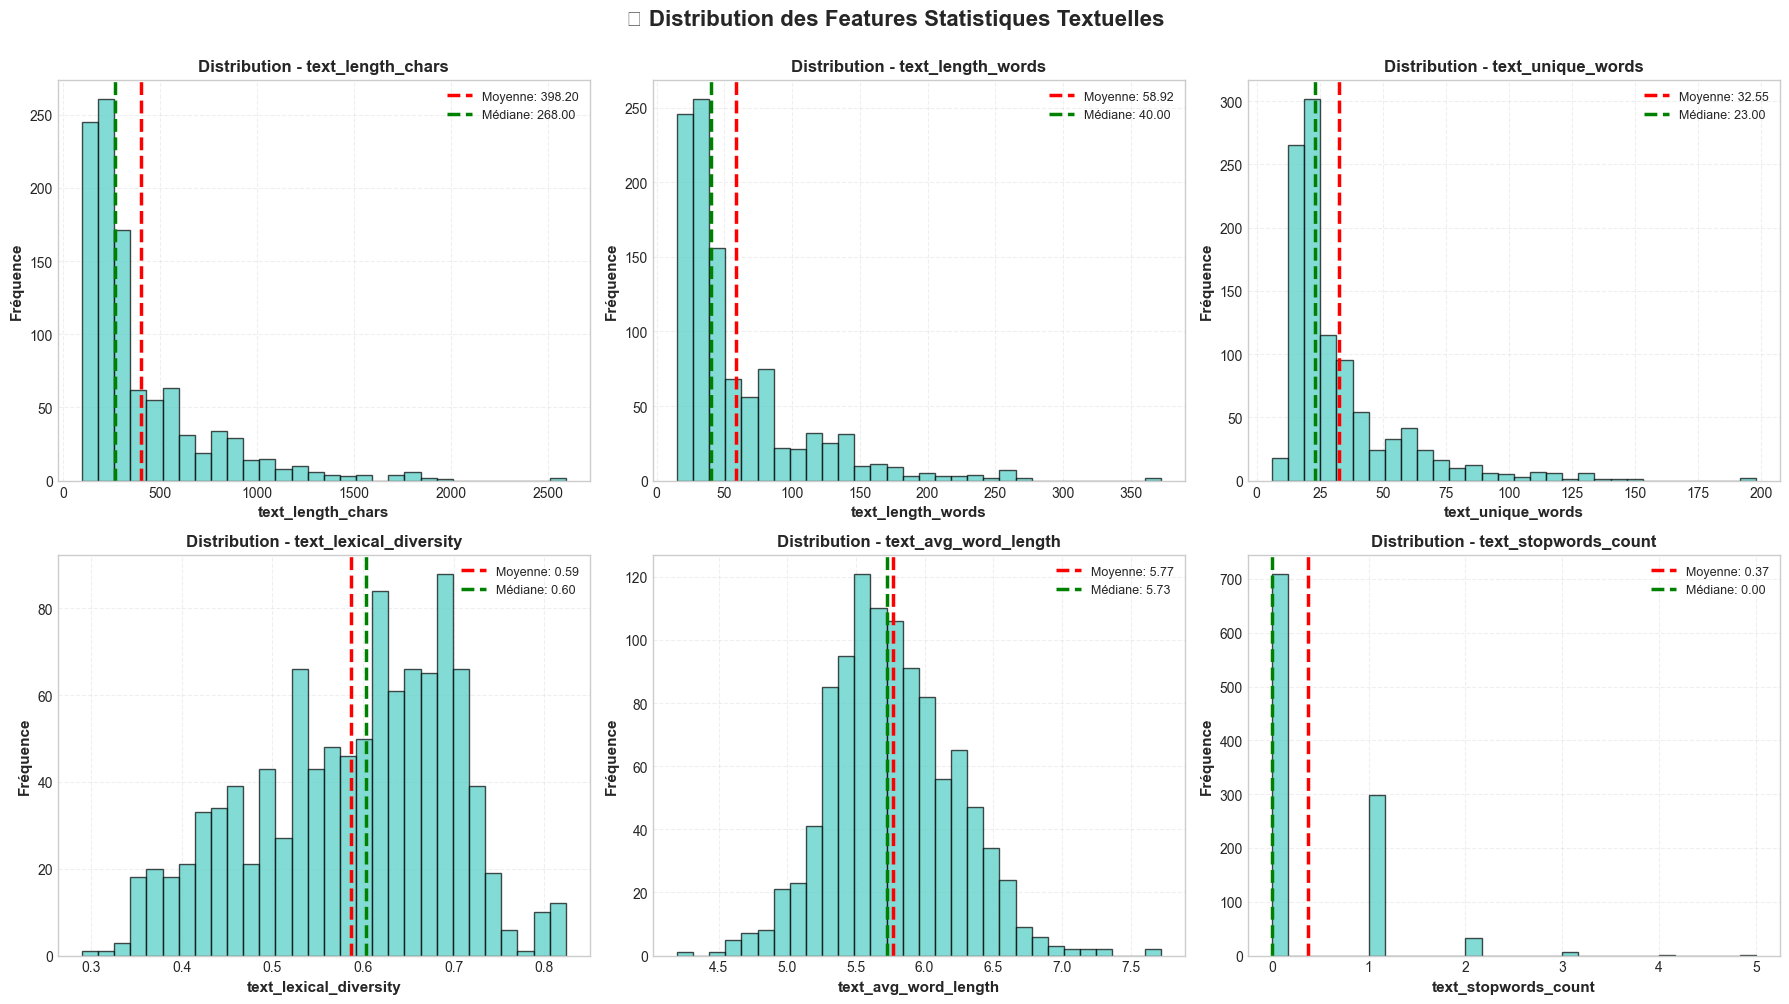

In [62]:
print("\n VISUALISATION DES FEATURES STATISTIQUES :\n")

n_features = len(stat_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.ravel()

for idx, feat in enumerate(stat_features):
    data = df_clean[feat].dropna()
    
    # Histogramme
    axes[idx].hist(data, bins=30, color=COLORS['info'], 
                  edgecolor='black', linewidth=1, alpha=0.7)
    axes[idx].axvline(data.mean(), color='red', linestyle='--', 
                     linewidth=2.5, label=f'Moyenne: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', 
                     linewidth=2.5, label=f'Médiane: {data.median():.2f}')
    
    axes[idx].set_xlabel(feat, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Distribution - {feat}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(alpha=0.3, linestyle='--')

# Cachons les axes non utilisés
for idx in range(len(stat_features), len(axes)):
    axes[idx].axis('off')

plt.suptitle('📊 Distribution des Features Statistiques Textuelles', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../outputs/text_statistics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*80)


### ENCODAGE DES FEATURES CATÉGORIELLES

In [63]:
print("\n" + "="*80)
print(" ENCODAGE DES FEATURES CATÉGORIELLES")
print("="*80 + "\n")

label_encoders = {}

if len(categorical_features) > 0:
    for col in categorical_features:
        if col in df_clean.columns:
            # Gestion des valeurs manquantes
            df_clean[col] = df_clean[col].fillna('Unknown')
            
            # Encodage avec LabelEncoder
            le = LabelEncoder()
            df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col])
            label_encoders[col] = le
            
            print(f"{col} encodé → {col}_encoded")
            print(f"   Nombre de valeurs uniques : {len(le.classes_)}")
            if len(le.classes_) <= 10:
                print(f"   Classes : {list(le.classes_)}")
    
    # Sauvegarde des encodeurs
    with open('../outputs/label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)
    
    print("\n Encodeurs sauvegardés dans 'label_encoders.pkl'")
else:
    print(" Aucune feature catégorielle à encoder")

print("="*80)



 ENCODAGE DES FEATURES CATÉGORIELLES

brand encodé → brand_encoded
   Nombre de valeurs uniques : 490

 Encodeurs sauvegardés dans 'label_encoders.pkl'


### ENCODAGE DU TARGET (CATÉGORIE)

In [64]:
print("\n" + "="*80)
print("ENCODAGE DU TARGET (CATÉGORIE)")
print("="*80 + "\n")

# Encodage de la catégorie cible
target_encoder = LabelEncoder()
df_clean['category_encoded'] = target_encoder.fit_transform(df_clean[category_target])

print(f" Catégorie '{category_target}' encodée → 'category_encoded'")
print(f"Nombre de classes : {len(target_encoder.classes_)}")
print(f"\n📊 Mapping des classes :")
for idx, category in enumerate(target_encoder.classes_):
    count = (df_clean['category_encoded'] == idx).sum()
    print(f"  {idx}: {category:30s} ({count:4d} produits, {count/len(df_clean)*100:5.1f}%)")

# Sauvegarde de l'encodeur du target
with open('../outputs/target_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

print("\n Encodeur du target sauvegardé dans 'target_encoder.pkl'")
print("="*80)



ENCODAGE DU TARGET (CATÉGORIE)

 Catégorie 'category_level1' encodée → 'category_encoded'
Nombre de classes : 7

📊 Mapping des classes :
  0: Baby Care                      ( 149 produits,  14.2%)
  1: Beauty and Personal Care       ( 150 produits,  14.3%)
  2: Computers                      ( 150 produits,  14.3%)
  3: Home Decor & Festive Needs     ( 150 produits,  14.3%)
  4: Home Furnishing                ( 150 produits,  14.3%)
  5: Kitchen & Dining               ( 150 produits,  14.3%)
  6: Watches                        ( 150 produits,  14.3%)

 Encodeur du target sauvegardé dans 'target_encoder.pkl'


#### VISUALISATION DE LA DISTRIBUTION DES CLASSES


 DISTRIBUTION DES CLASSES ENCODÉES



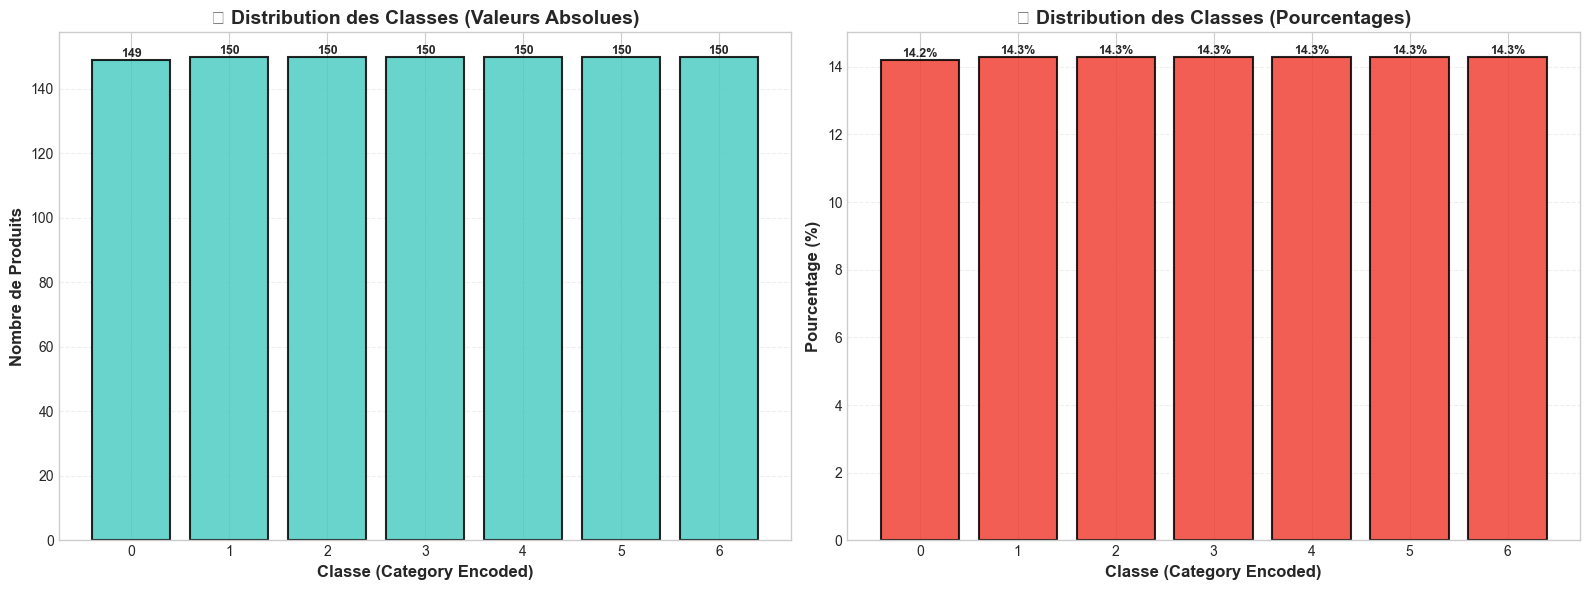

In [65]:
print("\n" + "="*80)
print(" DISTRIBUTION DES CLASSES ENCODÉES")
print("="*80 + "\n")

category_counts = df_clean['category_encoded'].value_counts().sort_index()

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique en barres
bars1 = axes[0].bar(category_counts.index, category_counts.values, 
                    color=COLORS['info'], edgecolor='black', linewidth=1.5, alpha=0.85)
axes[0].set_xlabel('Classe (Category Encoded)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre de Produits', fontsize=12, fontweight='bold')
axes[0].set_title('📊 Distribution des Classes (Valeurs Absolues)', 
                 fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Ajout des valeurs sur barres
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

# Graphique en pourcentages
percentages = (category_counts / len(df_clean) * 100).values
bars2 = axes[1].bar(category_counts.index, percentages, 
                    color=COLORS['warning'], edgecolor='black', linewidth=1.5, alpha=0.85)
axes[1].set_xlabel('Classe (Category Encoded)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('📊 Distribution des Classes (Pourcentages)', 
                 fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Ajout des valeurs sur barres
for bar, pct in zip(bars2, percentages):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*80)

### CRÉATION DES FEATURES TF-IDF


 CRÉATION DES FEATURES TF-IDF

 Formule TF-IDF :
  TF(w) = Nombre d'occurrences de w dans le document / Nombre total de mots
  IDF(w) = log(Nombre total de documents / Nombre de documents contenant w)
  TF-IDF(w) = TF(w) × IDF(w)

 Paramètres TF-IDF :
  • max_features: 3000
  • ngram_range: (1, 2)
  • min_df: 2
  • max_df: 0.8
  • sublinear_tf: True

 Application du TF-IDF (quelques instants)...

 TF-IDF créé avec succès !
  • Shape de la matrice : (1049, 3000)
  • Nombre de features : 3000
  • Sparsité : 98.39%
  • Vectorizer sauvegardé : tfidf_vectorizer.pkl

 Exemples de features TF-IDF (20 premiers) :
  ['1tb', '1tb win10', '26cm', '2gb', '3d', '4gb', '4gb 1tb', '4mm', '4mm model', '5cms', '5cms 5cms', '5mm', '5mm 4mm', '5th', '5th gen', '5v', '5v 95a', '5v 9a', '75w', '75w charger']

 Visualisation des top features TF-IDF...


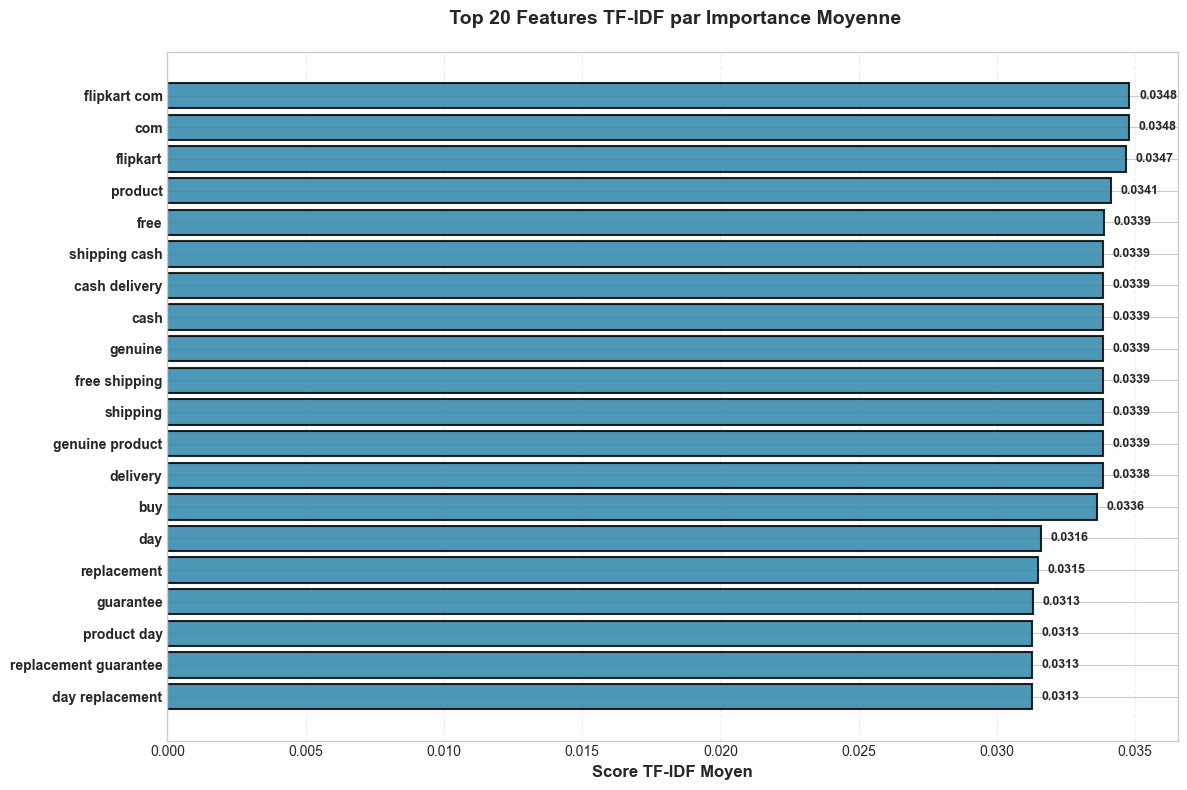

In [66]:
print("\n" + "="*80)
print(" CRÉATION DES FEATURES TF-IDF")
print("="*80 + "\n")

print(" Formule TF-IDF :")
print("  TF(w) = Nombre d'occurrences de w dans le document / Nombre total de mots")
print("  IDF(w) = log(Nombre total de documents / Nombre de documents contenant w)")
print("  TF-IDF(w) = TF(w) × IDF(w)")
print()

# Vérifions que nous avons des textes
if df_clean['text_combined'].str.len().sum() == 0:
    print(" ERREUR: Aucun texte disponible pour créer le TF-IDF!")
else:
    # Paramètres du TF-IDF
    tfidf_params = {
        'max_features': 3000,      # Nombre maximum de features
        'ngram_range': (1, 2),     # Unigrammes et bigrammes
        'min_df': 2,               # Ignorer termes dans < 2 documents
        'max_df': 0.8,             # Ignorer termes dans > 80% des documents
        'sublinear_tf': True       # Scaling logarithmique
    }
    
    print(f" Paramètres TF-IDF :")
    for param, value in tfidf_params.items():
        print(f"  • {param}: {value}")

    # Création du vectorizer
    tfidf_vectorizer = TfidfVectorizer(**tfidf_params)
    
    # Application du TF-IDF
    print("\n Application du TF-IDF (quelques instants)...")
    tfidf_features = tfidf_vectorizer.fit_transform(df_clean['text_combined'])
    
    print(f"\n TF-IDF créé avec succès !")
    print(f"  • Shape de la matrice : {tfidf_features.shape}")
    print(f"  • Nombre de features : {tfidf_features.shape[1]}")
    sparsity = (1 - tfidf_features.nnz / (tfidf_features.shape[0] * tfidf_features.shape[1])) * 100
    print(f"  • Sparsité : {sparsity:.2f}%")
    
    # Sauvegarde le vectorizer
    with open('../outputs/tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    
    print(f"  • Vectorizer sauvegardé : tfidf_vectorizer.pkl")
    
    # Affichage des top features
    feature_names = tfidf_vectorizer.get_feature_names_out()
    print(f"\n Exemples de features TF-IDF (20 premiers) :")
    print(f"  {list(feature_names[:20])}")
    
    # Visualisation des top features par importance moyenne
    print("\n Visualisation des top features TF-IDF...")
    mean_tfidf = np.asarray(tfidf_features.mean(axis=0)).ravel()
    top_indices = mean_tfidf.argsort()[-20:][::-1]
    top_features = feature_names[top_indices]
    top_scores = mean_tfidf[top_indices]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = np.arange(len(top_features))
    ax.barh(y_pos, top_scores, color=COLORS['primary'], 
            edgecolor='black', linewidth=1.5, alpha=0.85)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features, fontsize=10, fontweight='bold')
    ax.set_xlabel('Score TF-IDF Moyen', fontsize=12, fontweight='bold')
    ax.set_title(' Top 20 Features TF-IDF par Importance Moyenne', 
                fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.invert_yaxis()
    
    # Ajout valeurs
    for i, v in enumerate(top_scores):
        ax.text(v + max(top_scores)*0.01, i, f'{v:.4f}', 
                va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../outputs/tfidf_top_features.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*80)

### WORD EMBEDDINGS - WORD2VEC

In [76]:
try:
    import gensim
    from gensim.models import Word2Vec
    GENSIM_AVAILABLE = True
except ImportError:
    GENSIM_AVAILABLE = False

In [77]:
print("\n" + "="*80)
print(" WORD EMBEDDINGS - CRÉATION DE FEATURES MOYENNES")
print("="*80 + "\n")

print(" Approche : Utilisation de Word2Vec pour créer des features moyennes")
print("   → Plus léger que l'entraînement complet")
print("   → Peut être combiné avec TF-IDF pour les modèles classiques\n")

# Création du modèle Word2Vec
print(" Entraînement du modèle Word2Vec...")

# Préparation les sentences (listes de tokens)
sentences = [clean_text_advanced(text, return_tokens=True) 
             for text in df_clean['text_combined']]
sentences = [s for s in sentences if len(s) > 0]  # Filtrer vides

try:
    if not GENSIM_AVAILABLE:
        raise ImportError("Gensim non disponible")
    
    w2v_model = Word2Vec(
        sentences=sentences,
        vector_size=100,  # Dimension des vecteurs
        window=5,         # Fenêtre de contexte
        min_count=2,      # Fréquence minimale
        workers=4,        # Parallélisation
        sg=1,             # Skip-gram (1) ou CBOW (0)
        epochs=10         # Nombre d'époques
    )
    
    print(f" Modèle Word2Vec entraîné !")
    print(f"  • Vocabulaire : {len(w2v_model.wv)} mots")
    print(f"  • Dimension vecteurs : {w2v_model.wv.vector_size}")
    
    # Sauvegarde du modèle
    w2v_model.save('../outputs/word2vec_model.model')
    print(f"  • Modèle sauvegardé : word2vec_model.model")
    
    # Création des features moyennes par document
    print("\n⏳ Création des features moyennes par produit...")
    
    def document_vector(tokens, model):
        """Calcule le vecteur moyen d'un document"""
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(model.wv.vector_size)
    
    w2v_features = np.array([document_vector(sent, w2v_model) for sent in sentences])
    
    print(f"✅ Features Word2Vec créées : {w2v_features.shape}")
    
    # Visualisation de quelques mots similaires
    print("\n Exemples de mots similaires (Word2Vec) :")
    test_words = ['phone', 'laptop', 'camera', 'shirt', 'shoe', 'watch']
    for word in test_words:
        if word in w2v_model.wv:
            similar = w2v_model.wv.most_similar(word, topn=3)
            similar_str = ', '.join([f"{w}({s:.2f})" for w, s in similar])
            print(f"  • {word:10s} → {similar_str}")
        else:
            print(f"  • {word:10s} → (pas dans vocabulaire)")
    
except Exception as e:
    print(f" Erreur lors de l'entraînement Word2Vec : {e}")
    print("   → Création de features nulles")
    w2v_features = np.zeros((len(df_clean), 100))

print("\n" + "="*80)



 WORD EMBEDDINGS - CRÉATION DE FEATURES MOYENNES

 Approche : Utilisation de Word2Vec pour créer des features moyennes
   → Plus léger que l'entraînement complet
   → Peut être combiné avec TF-IDF pour les modèles classiques

 Entraînement du modèle Word2Vec...
 Modèle Word2Vec entraîné !
  • Vocabulaire : 3834 mots
  • Dimension vecteurs : 100
  • Modèle sauvegardé : word2vec_model.model

⏳ Création des features moyennes par produit...
✅ Features Word2Vec créées : (1049, 100)

 Exemples de mots similaires (Word2Vec) :
  • phone      → enabled(0.98), android(0.98), otg(0.97)
  • laptop     → reign(0.80), compatible(0.80), roman(0.79)
  • camera     → 7inch(0.98), compatibity(0.96), trapped(0.96)
  • shirt      → calculus(0.95), yk(0.94), stripped(0.94)
  • shoe       → (pas dans vocabulaire)
  • watch      → analog(0.91), men(0.88), sonata(0.84)



### PRÉPARATION DES FEATURES FINALES

In [78]:
print("\n" + "="*80)
print(" PRÉPARATION DES FEATURES FINALES")
print("="*80 + "\n")

# Conversion du TF-IDF en DataFrame
print(" Conversion des features en DataFrames...")

tfidf_df = pd.DataFrame(
    tfidf_features.toarray(), 
    columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])],
    index=df_clean.index
)
print(f" TF-IDF DataFrame : {tfidf_df.shape}")

# Conversion du Word2Vec en DataFrame
w2v_df = pd.DataFrame(
    w2v_features,
    columns=[f'w2v_{i}' for i in range(w2v_features.shape[1])],
    index=df_clean.index
)
print(f" Word2Vec DataFrame : {w2v_df.shape}")


# Création du DataFrame final
X_combined = pd.concat([
    tfidf_df.reset_index(drop=True),
    w2v_df.reset_index(drop=True)
], axis=1)

print(f"\n Features combinées : {X_combined.shape}")
print(f"   • TF-IDF : {tfidf_features.shape[1]}")
print(f"   • Word2Vec : {w2v_features.shape[1]}")
print(f"   • TOTAL : {X_combined.shape[1]}")

# Target
y = df_clean['category_encoded'].reset_index(drop=True)
print(f"\n Target (y) : {y.shape}")
print(f"   Distribution :\n{y.value_counts().sort_index().to_string()}")

print("\n" + "="*80)


 PRÉPARATION DES FEATURES FINALES

 Conversion des features en DataFrames...
 TF-IDF DataFrame : (1049, 3000)
 Word2Vec DataFrame : (1049, 100)

 Features combinées : (1049, 3100)
   • TF-IDF : 3000
   • Word2Vec : 100
   • TOTAL : 3100

 Target (y) : (1049,)
   Distribution :
category_encoded
0    149
1    150
2    150
3    150
4    150
5    150
6    150



### SPLIT TRAIN / VALIDATION / TEST (STRATIFIÉ)

In [79]:
print("\n" + "="*80)
print(" SPLIT DES DONNÉES (TRAIN / VALIDATION / TEST)")
print("="*80 + "\n")

# Configuration
test_size = 0.15
val_size = 0.15
random_state = 42

# Split 1 : Train+Val et Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_combined, y, 
    test_size=test_size, 
    random_state=random_state,
    stratify=y
)

# Split 2 : Train et Validation
val_size_adjusted = val_size / (1 - test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    random_state=random_state,
    stratify=y_temp
)

print(f"✅ Split stratifié effectué :")
print(f"   • Train      : {X_train.shape[0]:4d} samples ({X_train.shape[0]/len(X_combined)*100:5.1f}%)")
print(f"   • Validation : {X_val.shape[0]:4d} samples ({X_val.shape[0]/len(X_combined)*100:5.1f}%)")
print(f"   • Test       : {X_test.shape[0]:4d} samples ({X_test.shape[0]/len(X_combined)*100:5.1f}%)")
print(f"   • Shape features : {X_train.shape[1]} colonnes")

# Distribution des classes
print(f"\n Distribution des classes par ensemble :")
print(f"\nTrain :\n{y_train.value_counts().sort_index().to_string()}")
print(f"\nValidation :\n{y_val.value_counts().sort_index().to_string()}")
print(f"\nTest :\n{y_test.value_counts().sort_index().to_string()}")

print("\n" + "="*80)


 SPLIT DES DONNÉES (TRAIN / VALIDATION / TEST)

✅ Split stratifié effectué :
   • Train      :  733 samples ( 69.9%)
   • Validation :  158 samples ( 15.1%)
   • Test       :  158 samples ( 15.1%)
   • Shape features : 3100 colonnes

 Distribution des classes par ensemble :

Train :
category_encoded
0    104
1    105
2    105
3    105
4    105
5    104
6    105

Validation :
category_encoded
0    23
1    23
2    23
3    22
4    22
5    23
6    22

Test :
category_encoded
0    22
1    22
2    22
3    23
4    23
5    23
6    23



### VISUALISATION DE LA DISTRIBUTION APRÈS SPLIT


 VISUALISATION DE LA DISTRIBUTION APRÈS SPLIT :



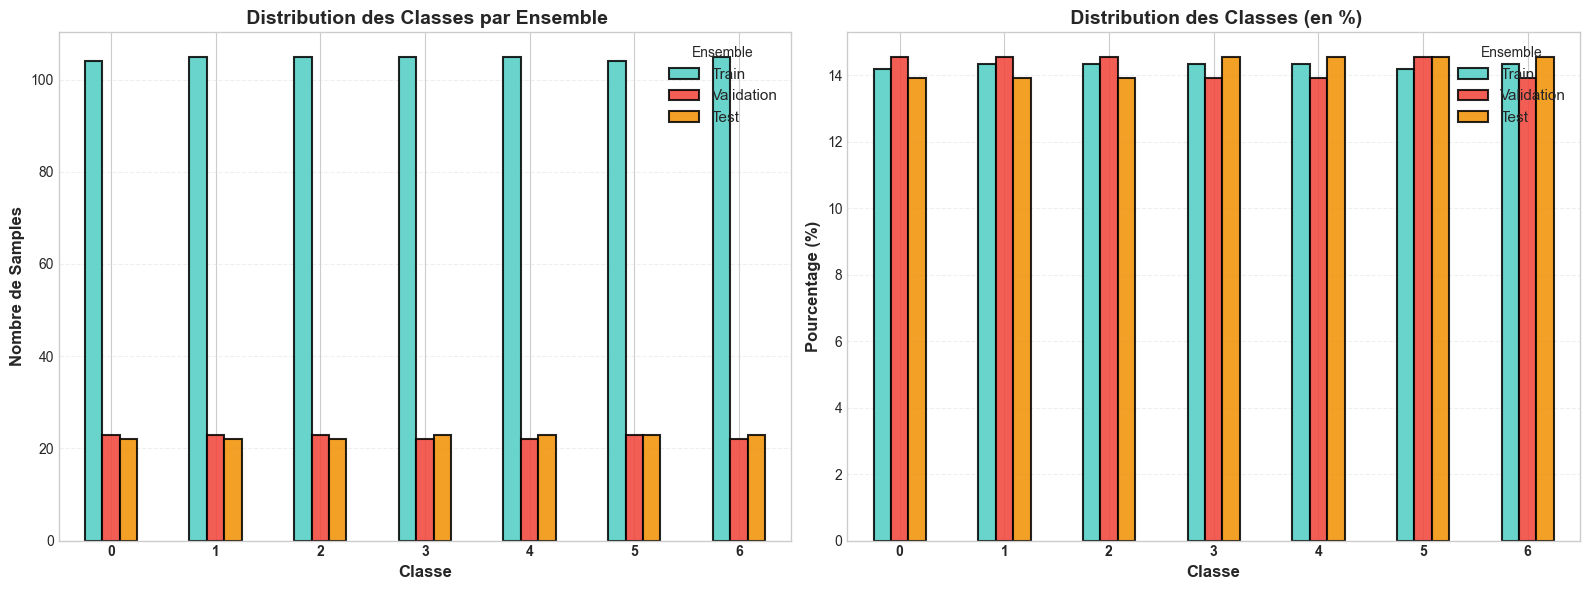

In [80]:
print("\n VISUALISATION DE LA DISTRIBUTION APRÈS SPLIT :\n")

# DataFrame pour visualisation
split_data = pd.DataFrame({
    'Train': y_train.value_counts().sort_index(),
    'Validation': y_val.value_counts().sort_index(),
    'Test': y_test.value_counts().sort_index()
})

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barres groupées (valeurs absolues)
split_data.plot(kind='bar', ax=axes[0], 
                color=[COLORS['info'], COLORS['warning'], COLORS['accent']],
                edgecolor='black', linewidth=1.5, alpha=0.85)
axes[0].set_xlabel('Classe', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre de Samples', fontsize=12, fontweight='bold')
axes[0].set_title(' Distribution des Classes par Ensemble', 
                 fontsize=14, fontweight='bold')
axes[0].legend(title='Ensemble', loc='best', fontsize=11)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, fontweight='bold')

# Pourcentages
split_data_pct = split_data.div(split_data.sum(axis=0), axis=1) * 100
split_data_pct.plot(kind='bar', ax=axes[1], 
                    color=[COLORS['info'], COLORS['warning'], COLORS['accent']],
                    edgecolor='black', linewidth=1.5, alpha=0.85)
axes[1].set_xlabel('Classe', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title(' Distribution des Classes (en %)', 
                 fontsize=14, fontweight='bold')
axes[1].legend(title='Ensemble', loc='best', fontsize=11)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*80)

### SAUVEGARDE DES DONNÉES PRÉPROCESSÉES

In [ ]:
print("\n" + "="*80)
print(" SAUVEGARDE DES DONNÉES PRÉPROCESSÉES")
print("="*80 + "\n")

preprocessed_data = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'feature_names': X_combined.columns.tolist(),
    'target_names': target_encoder.classes_.tolist(),
    'n_features': X_combined.shape[1],
    'n_classes': len(target_encoder.classes_),
    'tfidf_features': tfidf_features.shape,
    'w2v_features': w2v_features.shape
}

# Dans Notebook 2, après création du TF-IDF

for key in ['X_train', 'X_val', 'X_test']:
    df = preprocessed_data[key]
    for col in df.select_dtypes(include='string').columns:
        df[col] = df[col].astype('object')
    preprocessed_data[key] = df

# Puis sauvegarder
with open('../outputs/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)


print("✅ Données préprocessées sauvegardées : preprocessed_data.pkl")
print(f"   Contenu : X_train, X_val, X_test, y_train, y_val, y_test + metadata")

# Échantillon CSV pour visualisation
sample_size = min(100, len(X_train))
train_sample = pd.concat([
    X_train.head(sample_size).reset_index(drop=True),
    pd.DataFrame({'category_encoded': y_train.head(sample_size).values})
], axis=1)
train_sample.to_csv('../outputs/train_sample.csv', index=False)

print(f" Échantillon train sauvegardé : train_sample.csv ({sample_size} lignes)")

print("\n" + "="*80)


 SAUVEGARDE DES DONNÉES PRÉPROCESSÉES

✅ Données préprocessées sauvegardées : preprocessed_data.pkl
   Contenu : X_train, X_val, X_test, y_train, y_val, y_test + metadata
 Échantillon train sauvegardé : train_sample.csv (100 lignes)

